https://www.kaggle.com/stkbailey/teaching-notebook-for-total-imaging-newbies

https://www.kaggle.com/kmader/nuclei-overview-to-submission

https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0

https://personal.broadinstitute.org/anne/publications/127_Caicedo_NatMethods_2019.pdf

### Importing libraries 

In [1]:
# Importing libraries

# manipulating data
import numpy as np
import pandas as pd

# importing data
from glob import glob
import os
import pathlib
import imageio

# image processing
from skimage.io import (imread, imshow, imshow_collection)
from skimage.color import rgb2gray
from skimage.filters import (threshold_otsu, threshold_local)
from scipy import ndimage

from skimage import measure
from skimage import color
from skimage.util import view_as_blocks

# plotting data
import matplotlib.pyplot as plt
import seaborn as sns

### Importing and exploring dataframes

In [2]:
# Loading training dataframe
train_labels = pd.read_csv('stage1_train_labels.csv')

In [3]:
# Reading head of dataset
train_labels.head()

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3


In [4]:
# Number of samples
print("Number of images:", train_labels['ImageId'].unique().shape[0])
print("Number of lines:", train_labels.shape[0])

Number of images: 670
Number of lines: 29461


In [5]:
# Transforming EncodingPixels column from str into list
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda encodedp: [int(x) for x in encodedp.split(' ')])

In [6]:
# Reading head of dataset
train_labels.head()

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,"[6908, 1, 7161, 8, 7417, 8, 7672, 9, 7928, 9, ..."
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,"[36269, 7, 36523, 11, 36778, 13, 37033, 15, 37..."
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,"[19919, 6, 20174, 8, 20429, 10, 20685, 11, 209..."
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,"[18671, 6, 18926, 8, 19181, 9, 19436, 10, 1969..."
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,"[40158, 3, 40413, 5, 40669, 5, 40925, 5, 41182..."


In [7]:
# Taking image paths
dsb_data_dir = 'C:/Users/larissa.nukui/AppData/Local/Programs/Python/Python37/proj_int/data_spot_nuclei'
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*' ,'*','*','*'))
print(all_images[0])

# Transforming list of paths into dataframe
img_df = pd.DataFrame({'path': all_images})

C:/Users/larissa.nukui/AppData/Local/Programs/Python/Python37/proj_int/data_spot_nuclei\stage1_test\0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5\images\0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5.png


In [8]:
# Splitting informations in columns
img_df['ImageId'] = img_df['path'].map(lambda in_path: in_path.split('\\')[-3])
img_df['ImageType'] = img_df['path'].map(lambda in_path: in_path.split('\\')[-2])
img_df['TrainingSplit'] = img_df['path'].map(lambda in_path: in_path.split('\\')[-4].split('_')[1])
img_df['Stage'] = img_df['path'].map(lambda in_path: in_path.split('\\')[-4].split('_')[0])

In [9]:
img_df.head()

,path,ImageId,ImageType,TrainingSplit,Stage
0,C:/Users/larissa.nukui/AppData/Local/Programs/...,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,images,test,stage1
1,C:/Users/larissa.nukui/AppData/Local/Programs/...,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,images,test,stage1
2,C:/Users/larissa.nukui/AppData/Local/Programs/...,0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...,images,test,stage1
3,C:/Users/larissa.nukui/AppData/Local/Programs/...,0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd4...,images,test,stage1
4,C:/Users/larissa.nukui/AppData/Local/Programs/...,0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...,images,test,stage1


In [10]:
img_df.pivot_table(
    values='ImageId',
    index='ImageType',
    columns='TrainingSplit',
    aggfunc='count',
    fill_value=0,
    margins=True,
    margins_name='Total')

TrainingSplit,test,train,Total
ImageType,,,
images,65,670,735
masks,0,29461,29461
Total,65,30131,30196


### Dealing with color

In [11]:
# Glob the training data and load a single image path

# Creating object of image paths
training_paths = pathlib.Path('C:/Users/larissa.nukui/AppData/Local/Programs/Python/Python37/proj_int/data_spot_nuclei/stage1_train').glob('*/images/*.png')

# Transforming object into sorted list
training_sorted = sorted([x for x in training_paths])

In [12]:
len(training_sorted)

670

In [13]:
# Converting training images scale to gray

img_original = []
img_gray = []

for img_path in training_sorted:
    img = imageio.imread(str(img_path))
    img_original.append(img)
    img_gray.append(rgb2gray(img))

In [14]:
print(img_original[230].shape)
print(img_gray[230].shape)

(256, 320, 4)
(256, 320)


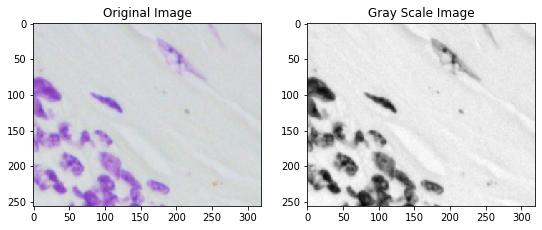

In [15]:
plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_original[230])
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(img_gray[230], cmap='gray')
plt.title('Gray Scale Image');

In [16]:
contours = measure.find_contours(img_gray[230], 0.7) 
len(contours)

23

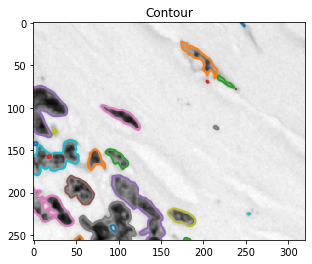

In [17]:
fig, axes = plt.subplots(figsize=(9, 4)) 

axes.imshow(img_gray[230], 
             cmap='gray', 
             interpolation='nearest')
axes.set_title('Contour')

for n, contour in enumerate(contours):   
        axes.plot(contour[:, 1], contour[:, 0],  linewidth=2)   
    

plt.show() 

### Removing background

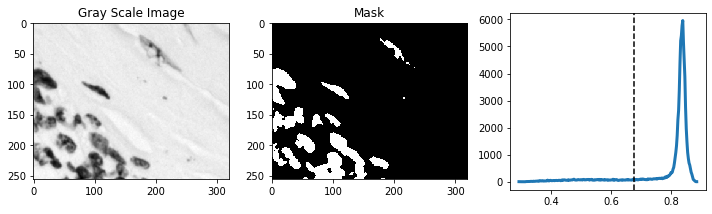

In [18]:
from skimage.filters import threshold_otsu
from skimage import data
from skimage import filters
from skimage import exposure

thresh_val = filters.threshold_otsu(img_gray[230])
hist, bins_center = exposure.histogram(img_gray[230])

plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.imshow(img_gray[230], cmap='gray', interpolation='nearest')
plt.title('Gray Scale Image')

plt.subplot(1, 3, 2)
plt.imshow(img_gray[230] < thresh_val, cmap='gray', interpolation='nearest')
plt.title('Mask')

plt.subplot(1, 3, 3)
plt.plot(bins_center, hist, lw=3)
plt.axvline(thresh_val, color='k', ls='--')

plt.tight_layout()
plt.show()

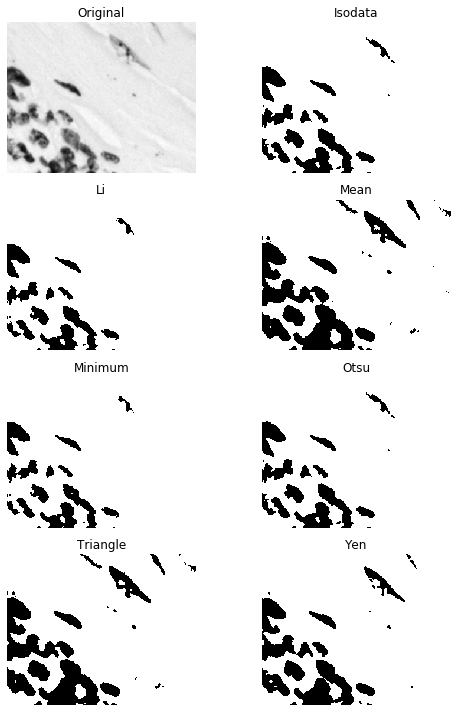

In [19]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(img_gray[230], figsize=(8, 10), verbose=False)
plt.show()

In [20]:
from skimage.filters import threshold_otsu

# Setting threshold
thresh_val = threshold_otsu(img_gray[230])

# Creating mask
mask = np.where(img_gray[230] > thresh_val, 1, 0)

# Make sure the larger portion of the mask is considered background
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

### Deriving individual masks for each object

In [21]:
from scipy import ndimage

# labels: mask labels, nlabels: number of label masks
labels, nlabels = ndimage.label(mask)

# creating list of mask arrays
label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print(nlabels, 'separate components/ objects detected')

21 separate components/ objects detected


In [22]:
segmented = label2rgb(labels, img_gray[230], kind='overlay')
plt.imshow(segmented);

NameError: name 'label2rgb' is not defined

In [ ]:
from skimage.color import rgb2gray

for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = img_gray[230][label_coords]
    print(label_coords)
    
    # Check if the label size is too small
    if np.product(cell.shape) < 10: 
        print('Label', label_ind, 'is too small. Setting to 0.')
        mask = np.where(labels==label_ind+1, 0, mask)

# Regenerate the labels
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

In [ ]:
# Get the object indices, and perform a binary opening procedure
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)